# 3.1 MNIST

MNIST 데이터셋은 손으로 쓴 70000개의 작은 숫자 이미지로 이뤄짐.
각 이미지는 해당 이미지가 어떤 숫자인지 레이블링이 되어있음.
새로운 분류 알고리즘이 나올 때마다 MNIST 데이터셋을 활용하여 잘 작동하는지 확인함.

In [1]:
import numpy as np

from sklearn.datasets import fetch_openml

import matplotlib as mpl

import matplotlib.pyplot as plt

from sklearn.linear_model import SGDClassifier #사이킷런의 확률적 경사 하강법 분류기.(선형분류) 한번에 하나씩 훈련 샘플을 독립적으로 처리.

from sklearn.model_selection import cross_val_score

from sklearn.base import BaseEstimator

from sklearn.model_selection import cross_val_predict

from sklearn.metrics import confusion_matrix

from sklearn.metrics import precision_score, recall_score, f1_score

from sklearn.metrics import precision_recall_curve

from sklearn.metrics import roc_curve

from sklearn.metrics import roc_auc_score

from sklearn.ensemble import RandomForestClassifier

In [2]:
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

사이킷런에서 불러들인 데이터셋은 일반적으로 비슷한 딕셔너리 구조를 가짐. 아래의 3가지 key는 보통 포함함.<br>
DESCR key: 데이터 셋을 설명<br>
data key: 샘플이 하나의 행, 특성이 하나의 열로 구성된 배열을 가짐<br>
target key: 레이블 배열을 담음.


In [3]:
X, y = mnist["data"], mnist["target"]
X.shape
#이미지가 70000개 있고 각 이미지별로 784개의 특성(28x28픽셀)이 있음.

(70000, 784)

In [4]:
y.shape #70000개의 이미지에 해당하는 레이블이 각각 한개, 총 70000여개 있음. (아마 0~9로 이뤄짐)

(70000,)

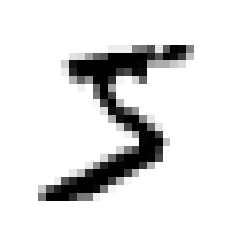

In [5]:
some_digit = X.values[0] #데이터셋 중 하나의 샘플을 확인해보기 위해서 지정
                         #X[0]에서 오류가 발생하는 이유는 scikitlearn의 버전에 따라 fetch_openml의 as_frame 인자의 default값이 다르기 때문.
                            #참고: https://github.com/ageron/handson-ml2/issues/352
some_digit_image = some_digit.reshape(28, 28) #reshape는 배열의 차원을 변경할때 사용함

plt.imshow(some_digit_image, cmap='binary') #imshow는 python에서 matplotlib을 활용해 이미지를 표시할 때 사용함. 
                                            #배열을 준 후 컬러맵으로 binary 옵션을 지정한 것.
                                            #출처: https://pyvisuall.tistory.com/78
plt.axis("off") #축은 표시 안함.
plt.show()

In [6]:
y[0] #y.values[0]을 사용해도 됨. 실제 레이블이 5임을 확인가능.

'5'

In [7]:
y = y.astype(np.uint8) #레이블 값이 문자열인데 머신러닝 알고리즘에서는 주로 정수형을 기대하므로 y의 값들을 모두 정수형으로 변환함.
                       #numpy의 데이터타입은 https://kongdols-room.tistory.com/53 참고

MNIST 데이터셋은 이미 training set와 test set을 60000, 10000으로 나눠놨음. 또한 훈련세트는 이미 잘 섞여 있음.(데이터 셋이 잘 섞여 있다.)<br>

In [8]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# 3.2 이진 분류기 훈련

데이터를 2가지 경우의 클래스로 분류하는 것을 이진 분류(binary classification)이라고 함.

1. 분류 작업을 위한 target vector를 만듦.

In [9]:
y_train_5 = (y_train == 5) #이 경우에 5는 True, 나머지 숫자는 모두 False가 됨.
y_test_5 = (y_test == 5)

여러 분류 모델이 있지만 확률적 경사 하강법을 예시로 들고 분류기로 사용해봄.

In [10]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

확률적 경사하강법 참고: https://gooopy.tistory.com/69

In [11]:
sgd_clf.predict([some_digit]) #맨 처음 지정한 이미지를 5라고 판단함. 하지만 이 한번의 경우로 모델의 성능을 평가할 수 없음.

array([ True])

# 3.3 성능 측정

classifier 평가는 회귀 모델 평가보다 어려움.<br>
또한 모델 평가에 사용할 수 있는 성능 지표로 여러개가 존재함.<br>
아래의 방법을 활용하여 성능을 측정하는 것은 모델들을 비교하기 위함.<br>
1. 교차 검증을 활용한 정확도 측정
2. 오차 행렬(confusion matrix) 계산
3. 정밀도와 재현율 활용
4. ROC 곡선(수신기 조작 특성 곡선) 활용

## 3.3.1 교차 검증을 사용한 정확도 측정

1) scikitlearn의 cross_val_score 활용 (cv=k에 주는 k의 값에 따라 k-겹 교차 검증을 사용함  
cf) k-겹 교차 검증에서는 훈련 세트를 k개의 폴드로 나누고 각 폴드에 대해 예측을 만든 후 평가하는데 나머지 폴드로 훈련시킨 모델을 사용함.

In [12]:
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy') #모든 교차 검증 폴드에 대해 정확도가 95% 이상.


array([0.95035, 0.96035, 0.9604 ])

모든 이미지를 5가 아닌(False)로 판단하는 더미 분류기를 사용 -> SGDClassifier과 정확도가 별 차이 없음.   
교차 검증이 모델을 평가하는 좋은 방법이지만,
분류기의 성능지표로는 정확도가 사용되기 어렵다는 한계를 보여줌.  
(특히 특정 클래스가 다른 것보다 월등히 많은 불균형한 데이터 셋에서)

In [13]:
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [14]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

## 3.3.2 오차 행렬(confusion matrix) 계산

In [15]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

오차 행렬을 만들려면 실제 target과 비교할 수 있도록 예측값을 만들어야 함.  
하지만 이때 test set을 사용할 순 없으므로 cross_val_predict()를 활용함.   
cross_val_predict()는 cross_val_score()처럼 k-겹 교차 검증을 수행하지만 각 테스트 폴드에서 얻은 예측을 반환한다는 차이가 있음.

In [16]:
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

tn, fp // 5아님으로 잘  분류, 5가 아닌데 5라고 잘못 분류  
fn, tp // 5가 맞는데 5가 아니라고 잘못 분류, 5가 맞다고  잘 분류  
행이 actual class, 열이 predictive class라고 생각하기. 


더 요약된 지표로 precision(정밀도), recall(재현율), sensitivity(민감도), TPR(진짜 양성 비율), F1 score 등도 있음.  -> 데사시간에 배움.

## 3.3.3 정밀도와 재현율, 3.3.4 정밀도/재현율 트레이드 오프

오차행렬을 구한후 정밀도(precision)과 재현율(recall)를 직접 계산해도 되지만 scikitlearn에 관련 함수가 있음.

In [17]:
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [18]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [19]:
f1_score(y_train_5, y_train_pred)

0.7325171197343846

precision_score : 5로 감지된 숫자 중에서 실제 5의 비율.   
recall_score: 실제 5 중에서 5로 감지된 숫자의 비율.  
f1_score: 정밀도와 재현율의 조화 평균 -> 두 분류기를 비교할 때 사용

상황에 따라 정밀도가 중요할 수도 있고 재현율이 중요할 수도 있음.  
이 둘을 모두 얻긴 어렵고 한 값이 증가하면 다른 값이 감소하는 것을 정밀도/재현율 트레이드오프라고 함.

SGDClassifier는 threshold(임계값)에 따라 분류를 진행함(이 과정을 decision function이 진행).  
이때 임계값을 높일경우 일반적으로 재현율(tp/(tp+fn))이 낮아지고 정밀도(tp/(tp+fp))가 높아짐.  

In [20]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores #scikit learn에서 임계값을 지정할 수는 없지만 decision_function()을 활용해,  각 샘플에 사용된 임계값을 확인할 수는 있음.

array([2164.22030239])

In [21]:
threshold = 3000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred #사용된 임계값보다 큰 3000을 threshold로 사용할 경우 false(5가 아님)이 나오는 걸 확인가능.

array([False])

적절한 임계값은 좋은 정밀도/재현율 트레이드오프를 선택하는 것에 따라 결정됨.  
재현율에 대한 정밀도 곡선을 그린 후 정밀도가 급격하게 줄어들기 시작하는 재현율을 찾아 그 하강점 직전을 선택하면 됨.<br>
cf) 프로젝트의 목표에 따라 정밀도를 높이고 싶으면 그냥 큰 임계값을 선택하면 되는 등 프로젝트의 목표에 따라 적절한 정밀도와 재현율은 달라질 수 있음.

In [22]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")
#예측 결과가 아닌 결정 점수를 반환받을 수 있도록 cross_val_predict()를 사용하되, method="decision_function"을 추가.

In [23]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)
#가능한 모든 임계값에 대해 precisions, recall, thresholds를 계산함.

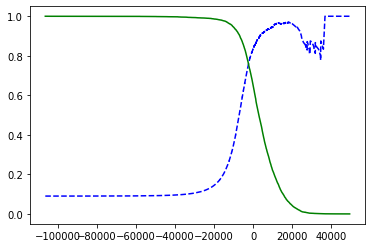

In [24]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="정밀도") #파란 점선
    plt.plot(thresholds, recalls[:-1], "g-", label="재현율") #초록 실선

# cf) [:-1]은 배열의 마지막 원소를 제외한 배열을 의미함.

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()
    


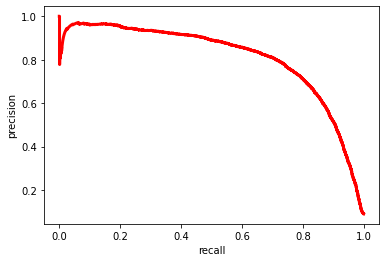

In [25]:
line = plt.plot(recalls[:-1], precisions[:-1])
plt.xlabel("recall")
plt.ylabel("precision")
plt.setp(line, 'color', 'r', 'linewidth', 3.0)
plt.show()

재현율에 대한 정밀도 곡선을 그린 후 정밀도가 급격하게 줄어들기 시작하는 재현율을 찾아 그 하강점 직전을 선택하면 됨.<br>

In [26]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)] #프로젝트의 목표가 정밀도 90%를 달성하는 것일때의 최소 임계값
threshold_90_precision

3370.019499143958

훈련세트에 대한 예측을 만들려면 분류기의 predict()메서드를 호출하는 대신 아래의 코드를 실행 가능함.

In [27]:
y_train_pred_90 = (y_scores >= threshold_90_precision)
precision_score(y_train_5, y_train_pred_90)


0.9000345901072293

In [28]:
recall_score(y_train_5, y_train_pred_90) #정밀도가 90%를 달성하는 것이 목표였기에 재현율을 신경쓰지 못함. 재현율이 너무 낮다면 높은 정밀도의 분류기는 유용하지 않음.

0.4799852425751706

## 3.3.5 ROC 곡선

앞에서 재현율에 대한 정밀도 곡선을 그렸다면 ROC곡선은 거짓양성비율(FPR)에 대한 진짜양성비율(TPR=recall) 곡선을 말함.<br>
TPR = recall = tp / (tp+fn)<br>
FPR = n인데 p로 판단 / 실제 n = fp / (fp+tn) = 1 - tn / (fp + tn) = 1 - TN = 1 - 진짜음성비율<br>


In [29]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

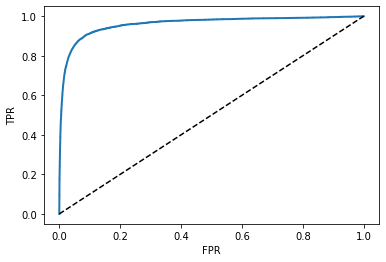

In [30]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth = 2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')

plot_roc_curve(fpr,tpr)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

TPR이 높을 수록 분류기가 만드는 FPR이 늘어나는 트레이드 오프가 있음.<br>
가운데 점선은 완전한 랜덤 분류기의 ROC 곡선인데 좋은 분류기일 수록 이 점선에서 최대한 멀리, 왼쪽 모서리에 떨어져 있어야 함.<br>
더 정확하게 비교하려면 곡선 아래의 면적을 구해서 1에 가까울수록 완벽한 분류기이고 0.5에 가까울수록 완전한 랜덤 분류기에 가까움.<br>

In [31]:
roc_auc_score(y_train_5, y_scores) #곡선 아래의 면적을 AUC(area under the curve)라 함.

0.9604938554008616

정밀도/재현율 곡선: 양성 클래스가 드물거나 fn보다 fp가 중요한 경우에 주로 사용. 
ROC곡선: 정밀도/재현율 곡선과 반대의 경우에 사용.  
cf) 위의 경우에서 auc가 0.96이여서 좋은 분류기라고 생각할 수 있는데 이는 양성 클래스가 매우 적어서 나온 결과임. 따라서 위의 경우에서는 정밀도/재현율 곡선을 사용하는게 나음.

In [32]:
forest_clf = RandomForestClassifier #sgd_clf와 roc곡선 및 roc auc를 비교해보기 위해 forest_clf를 훈련시킴
forest_clf = RandomForestClassifier(random_state = 42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")
#forest_clf에서 sgd_clf의 decision_function()역할을 하는 함수는 predict_proba()

In [33]:
y_scores_forest = y_probas_forest[:, 1] #양성 클래스에 대한 확률을 점수로 사용
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

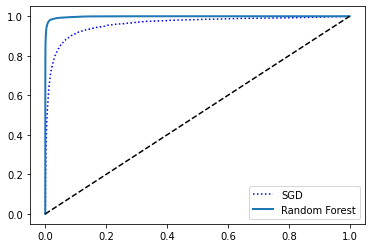

In [34]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [35]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [36]:
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_probas_forest)

0.9905083315756169

In [37]:
recall_score(y_train_5, y_probas_forest)

0.8662608374838591

roc auc점수와 정밀도, 재현율 모두 sgd_clf보다 forest_clf가 좋다는 것을 확인 가능.